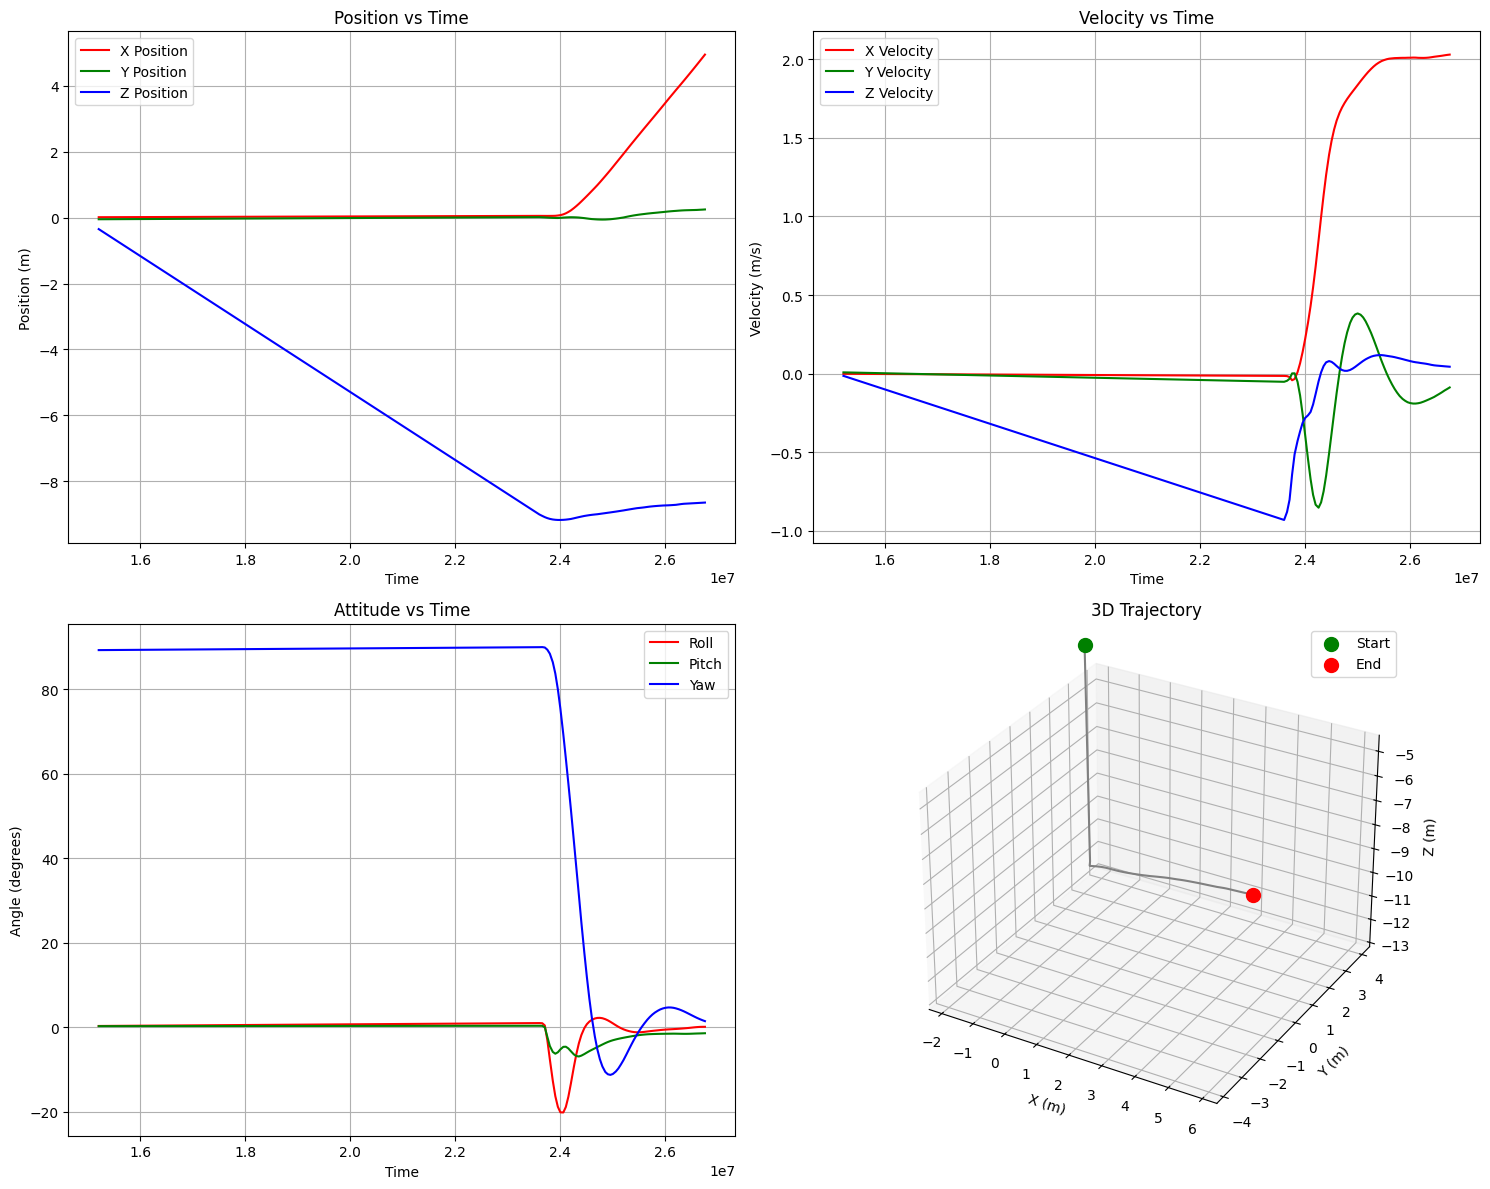

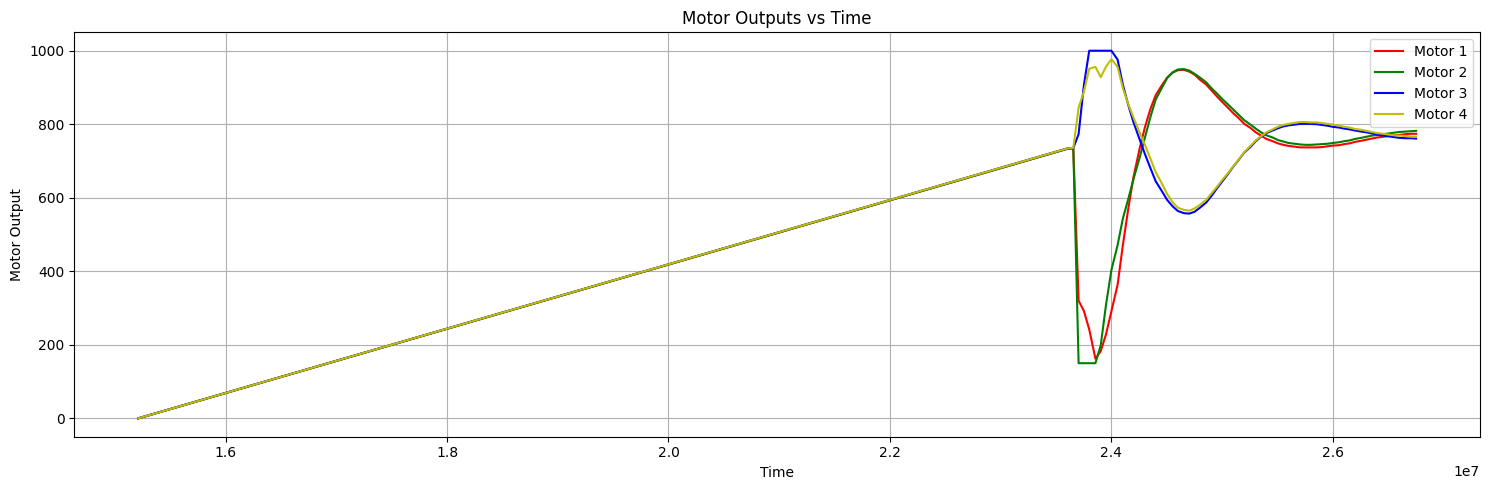

In [6]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/home/eashan/workspace/DreamingFalconROS/flight_logs/flight_data_20250410-131339.csv')

# Access the data
positions = df[['x', 'y', 'z']].values
velocities = df[['vx', 'vy', 'vz']].values
attitudes = df[['roll', 'pitch', 'yaw']].values

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Check if there's a timestamp column, otherwise create one
if 'timestamp' in df.columns:
    time_data = df['timestamp'].values
else:
    time_data = np.arange(len(df))

# Create 4 subplots in a 2x2 grid
fig = plt.figure(figsize=(15, 12))

# 1. Position plot
ax1 = fig.add_subplot(221)
ax1.plot(time_data, df['x'], 'r-', label='X Position')
ax1.plot(time_data, df['y'], 'g-', label='Y Position')
ax1.plot(time_data, df['z'], 'b-', label='Z Position')
ax1.set_title('Position vs Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position (m)')
ax1.grid(True)
ax1.legend()

# 2. Velocity plot
ax2 = fig.add_subplot(222)
ax2.plot(time_data, df['vx'], 'r-', label='X Velocity')
ax2.plot(time_data, df['vy'], 'g-', label='Y Velocity')
ax2.plot(time_data, df['vz'], 'b-', label='Z Velocity')
ax2.set_title('Velocity vs Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Velocity (m/s)')
ax2.grid(True)
ax2.legend()

# 3. Attitude plot
ax3 = fig.add_subplot(223)
ax3.plot(time_data, np.degrees(df['roll']), 'r-', label='Roll')
ax3.plot(time_data, np.degrees(df['pitch']), 'g-', label='Pitch')
ax3.plot(time_data, np.degrees(df['yaw']), 'b-', label='Yaw')
ax3.set_title('Attitude vs Time')
ax3.set_xlabel('Time')
ax3.set_ylabel('Angle (degrees)')
ax3.grid(True)
ax3.legend()

# 4. 3D trajectory plot
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot3D(df['x'], df['y'], df['z'], 'gray')
ax4.scatter(df['x'].iloc[0], df['y'].iloc[0], df['z'].iloc[0], 
           color='green', marker='o', s=100, label='Start')
ax4.scatter(df['x'].iloc[-1], df['y'].iloc[-1], df['z'].iloc[-1], 
           color='red', marker='o', s=100, label='End')
ax4.set_title('3D Trajectory')
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
ax4.set_zlabel('Z (m)')
ax4.legend()

# Make the axes equal for the 3D plot to avoid distortion
max_range = max(
    np.ptp(df['x']), 
    np.ptp(df['y']), 
    np.ptp(df['z'])
)
mid_x = np.mean(df['x'])
mid_y = np.mean(df['y'])
mid_z = np.mean(df['z'])
ax4.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
ax4.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
ax4.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

plt.tight_layout()
plt.show()

# Additionally, let's create plots for the motor outputs
plt.figure(figsize=(15, 5))
plt.plot(time_data, df['motor1'], 'r-', label='Motor 1')
plt.plot(time_data, df['motor2'], 'g-', label='Motor 2')
plt.plot(time_data, df['motor3'], 'b-', label='Motor 3')
plt.plot(time_data, df['motor4'], 'y-', label='Motor 4')
plt.title('Motor Outputs vs Time')
plt.xlabel('Time')
plt.ylabel('Motor Output')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

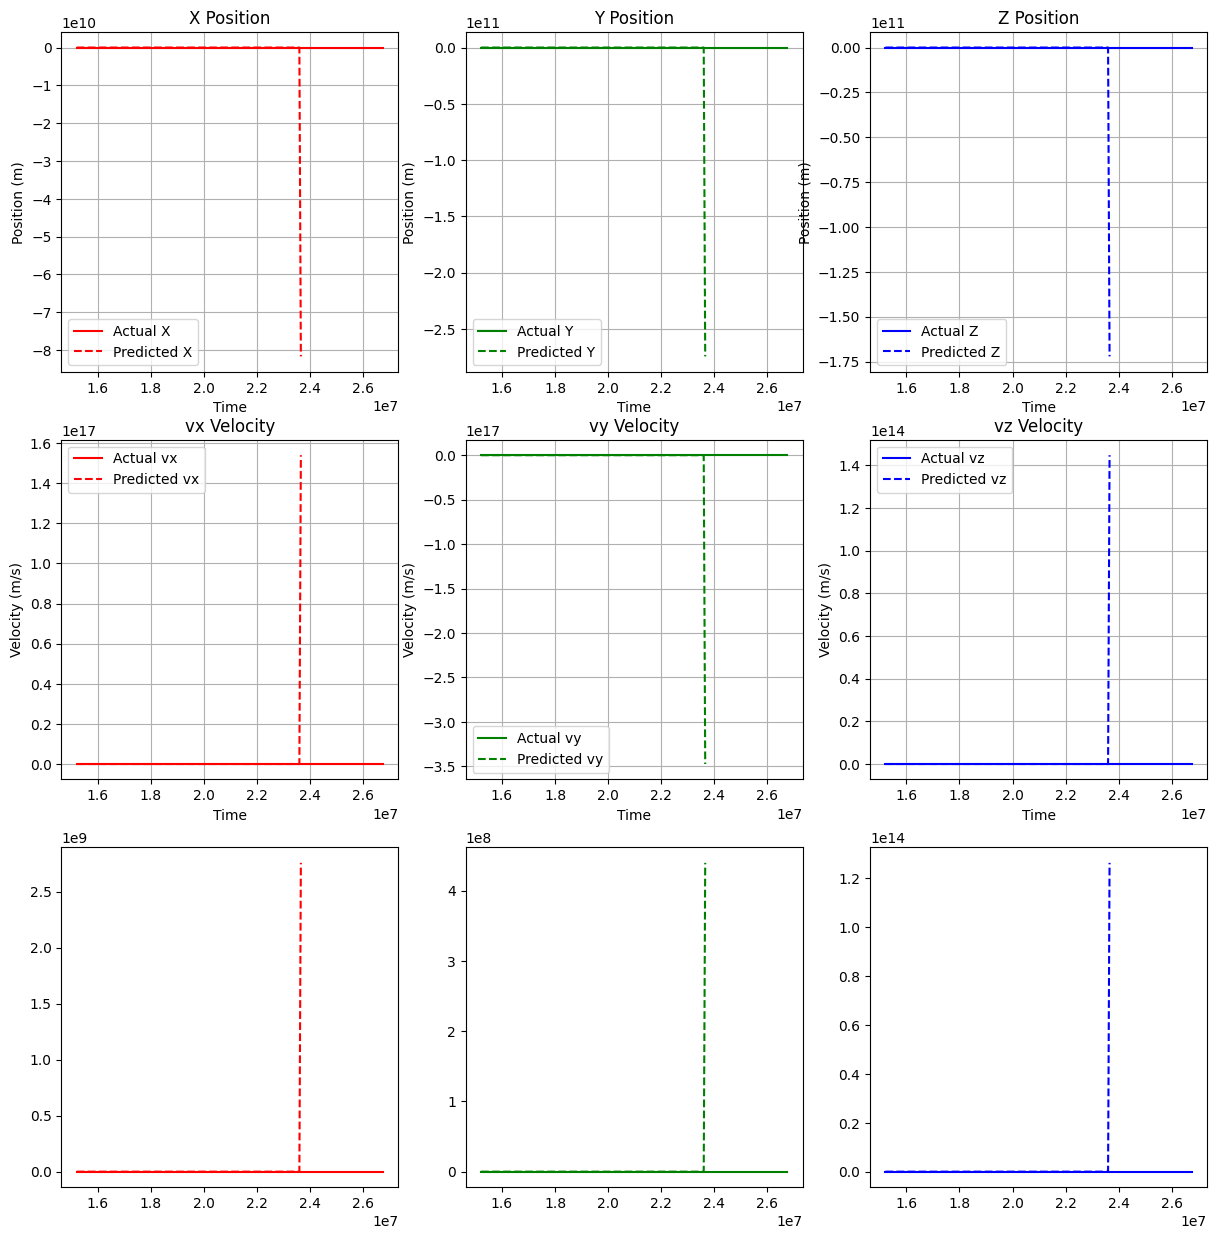

In [7]:
# For loop to take state and action from the data frame and use WorldModel to predict rollout sequence
import torch
from models import WorldModel
from utils import AttrDict
import yaml

# Initialize arrays to store predictions
predicted_states = []
actual_states = []

# Get the initial state
initial_state = torch.tensor(df.iloc[0][['x', 'y', 'z', 'vx', 'vy', 'vz', 
                                        'roll', 'pitch', 'yaw', 
                                        'roll_rate', 'pitch_rate', 'yaw_rate']].values, 
                            dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Store the initial state for both actual and predicted
current_pred_state = initial_state
actual_states.append(initial_state.squeeze(0).cpu().numpy())
predicted_states.append(initial_state.squeeze(0).cpu().numpy())

with open("/home/eashan/workspace/DreamingFalconROS/config.yaml", 'r') as file:
    config_dict = yaml.safe_load(file)

config = AttrDict.from_dict(config_dict)
world_model = WorldModel(config, torch.device(config.device)).to(config.device)
checkpoint = torch.load("/home/eashan/workspace/DreamingFalconROS/models/run_x/model.pt")
world_model.load_state_dict(checkpoint["state_dict"])
world_model.eval()  # Set to evaluation mode


# Loop through the data frame (starting from index 1)
with torch.no_grad():
    for i in range(1, len(df)):
        # Get dt and action from data frame
        dt = torch.tensor([df.iloc[i-1]['dt']], dtype=torch.float32).unsqueeze(0)
        action = torch.tensor(df.iloc[i-1][['motor1', 'motor2', 'motor3', 'motor4']].values, 
                             dtype=torch.float32).unsqueeze(0)
        
        # Get actual state for this timestep
        actual_state = torch.tensor(df.iloc[i][['x', 'y', 'z', 'vx', 'vy', 'vz', 
                                              'roll', 'pitch', 'yaw', 
                                              'roll_rate', 'pitch_rate', 'yaw_rate']].values, 
                                   dtype=torch.float32).unsqueeze(0)
        
        # Predict next state using world model
        next_pred_state = world_model.predict(dt, current_pred_state, action)
        
        # Store predictions and actual states
        predicted_states.append(next_pred_state.squeeze(0).cpu().numpy())
        actual_states.append(actual_state.squeeze(0).cpu().numpy())
        
        # Update current predicted state
        current_pred_state = next_pred_state

# Convert lists to numpy arrays
predicted_states = np.array(predicted_states)
actual_states = np.array(actual_states)

# Create visualization comparing actual vs predicted
plt.figure(figsize=(20, 15))

# Position plots
for i, (axis, color) in enumerate(zip(['x', 'y', 'z'], ['r', 'g', 'b'])):
    plt.subplot(3, 4, i+1)
    plt.plot(time_data, actual_states[:, i], f'{color}-', label=f'Actual {axis.upper()}')
    plt.plot(time_data, predicted_states[:, i], f'{color}--', label=f'Predicted {axis.upper()}')
    plt.title(f'{axis.upper()} Position')
    plt.xlabel('Time')
    plt.ylabel('Position (m)')
    plt.grid(True)
    plt.legend()

# Velocity plots
for i, (axis, color) in enumerate(zip(['vx', 'vy', 'vz'], ['r', 'g', 'b'])):
    plt.subplot(3, 4, i+5)
    plt.plot(time_data, actual_states[:, i+3], f'{color}-', label=f'Actual {axis}')
    plt.plot(time_data, predicted_states[:, i+3], f'{color}--', label=f'Predicted {axis}')
    plt.title(f'{axis} Velocity')
    plt.xlabel('Time')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()

# Attitude plots (in degrees)
for i, (axis, color) in enumerate(zip(['roll', 'pitch', 'yaw'], ['r', 'g', 'b'])):
    plt.subplot(3, 4, i+9)
    plt.plot(time_data, np.degrees(actual_states[:, i+6]), f'{color}-', label=f'Actual {axis}')
    plt.plot(time_data, np.degrees(predicted_states[:, i+6]), f'{color}--', label=f'Predicted {axis}')